It has been done according to the research paper,

K. Altun, B. Barshan, and O. Tunçel, Comparative study on classifying human activities with miniature inertial and magnetic sensors, Pattern Recognition, 43(10):3605-3620, October 2010.

Where they take the input segment, that's a 5 second window of a patient performing an activity, which has 125 observations ( 5 x 25Hz ) with 45 features, because of 9 axes of each sensor unit on torso, left hand, right hand, left leg, right leg. They convert the 125x45 into a handcrafted meaningful 1170x1 matrix.

The 1170 features represents,

* 225 features ( min, max, mean, skewness, kurtosis of all 9 axes of all 5 units, thus 5x9x5 ) i.e., first_step
* 225 features which represent the maximum 5 peaks of the DFT applied on each of the 9 axes of all the 5 units i.e.,
second_step
* 225 features which represent the corresponding frequency of the 5 peaks of the DFT over the time series i.e.,
third_step.
* 495 features which represent the autocorrelation of the series, 11 hand picked values from the 125 
autocorrelation values for each axes, thus 11 x 9 x 5 = 495 i.e, fourth_step.

Adding them all 225 + 225 + 225 + 495 = 1170, for each segment, i.e., each text file.

Then these values are normalized in the range [0,1], and stored along with the patient ID and activity ID for that segment / text file.

The test I performed includes two parts, one with 9120 x 1170 matrix, and another with 9120 x 30 matrix, I did PCA over the initial matrix, unfortunately, the PCA didn't live up to my expectations, so I'm producing both results.

I request you to consider my 9120 x 1170 dataset into consideration, and its results.

## Preprocessing


In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
df = pd.read_csv('data/a01/p1/s01.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,8.1305,1.0349,5.4217,-0.009461,0.001915,-0.003424,-0.78712,-0.069654,0.15730,0.70097,...,-0.036453,-2.8071,-9.0812,2.6220,-0.000232,-0.012092,-0.004457,0.74017,0.30053,-0.057730
1,8.1305,1.0202,5.3843,-0.009368,0.023485,0.001953,-0.78717,-0.068275,0.15890,0.71829,...,-0.034005,-2.8146,-9.0737,2.6218,-0.014784,-0.016477,0.002789,0.73937,0.30183,-0.057514
2,8.1604,1.0201,5.3622,0.015046,0.014330,0.000204,-0.78664,-0.068277,0.15879,0.69849,...,-0.036489,-2.8221,-9.0886,2.6366,-0.012770,0.005717,-0.007918,0.73955,0.30052,-0.057219
3,8.1603,1.0052,5.3770,0.006892,0.018045,0.005649,-0.78529,-0.069849,0.15912,0.72799,...,-0.036151,-2.8071,-9.0811,2.6070,-0.005725,0.009620,0.006555,0.74029,0.30184,-0.057750
4,8.1605,1.0275,5.3473,0.008811,0.030433,-0.005346,-0.78742,-0.068796,0.15916,0.71572,...,-0.033807,-2.8146,-9.0737,2.6218,-0.003929,-0.008371,0.002816,0.73845,0.30090,-0.057527


In [3]:
## # we need to convert these 125 x 45 columns into 1170 x 1

In [4]:
df.describe()


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,7.975714,1.083150,5.606846,0.004897,0.026123,-0.003726,-0.790726,-0.068490,0.135897,0.679134,...,-0.035894,-2.814833,-9.085131,2.618207,-0.005036,0.002166,-0.003155,0.739615,0.301314,-0.057119
std,0.119981,0.046987,0.181035,0.015592,0.036279,0.007920,0.002870,0.001751,0.015907,0.039324,...,0.001074,0.019892,0.013178,0.018793,0.007633,0.007310,0.007074,0.000850,0.000792,0.000823
min,7.682300,0.997440,5.316900,-0.039399,-0.080639,-0.030754,-0.795540,-0.071582,0.109560,0.585420,...,-0.039347,-2.867500,-9.112400,2.571100,-0.024685,-0.019207,-0.021531,0.737520,0.299680,-0.059241
25%,7.876300,1.035000,5.436400,-0.005710,0.010725,-0.008867,-0.793210,-0.069849,0.119820,0.649210,...,-0.036599,-2.822500,-9.089400,2.608400,-0.009489,-0.003025,-0.007918,0.739000,0.300710,-0.057598
50%,7.958700,1.080700,5.608100,0.005122,0.023588,-0.003457,-0.791610,-0.068773,0.135040,0.688700,...,-0.035765,-2.815000,-9.088600,2.622000,-0.005644,0.001586,-0.002558,0.739550,0.301320,-0.057208
75%,8.108200,1.124000,5.749300,0.014090,0.043022,0.001953,-0.787430,-0.067195,0.155050,0.708470,...,-0.035240,-2.807500,-9.074500,2.625000,-0.000232,0.007598,0.001253,0.740240,0.301830,-0.056500
max,8.160500,1.183200,6.181400,0.045403,0.214760,0.015614,-0.785290,-0.064353,0.159160,0.759300,...,-0.033109,-2.747600,-9.044500,2.669600,0.015853,0.020288,0.013777,0.742380,0.303420,-0.054963


#### Calculating min, max, mean, skew and curtosis for all 45 axes.



In [5]:
first_step = list(df.min())+list(df.max())+list(df.mean())+list(df.skew())+list(df.kurtosis())
len(first_step)

225

#### calculate dft

In [6]:
df.head()


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,8.1305,1.0349,5.4217,-0.009461,0.001915,-0.003424,-0.78712,-0.069654,0.15730,0.70097,...,-0.036453,-2.8071,-9.0812,2.6220,-0.000232,-0.012092,-0.004457,0.74017,0.30053,-0.057730
1,8.1305,1.0202,5.3843,-0.009368,0.023485,0.001953,-0.78717,-0.068275,0.15890,0.71829,...,-0.034005,-2.8146,-9.0737,2.6218,-0.014784,-0.016477,0.002789,0.73937,0.30183,-0.057514
2,8.1604,1.0201,5.3622,0.015046,0.014330,0.000204,-0.78664,-0.068277,0.15879,0.69849,...,-0.036489,-2.8221,-9.0886,2.6366,-0.012770,0.005717,-0.007918,0.73955,0.30052,-0.057219
3,8.1603,1.0052,5.3770,0.006892,0.018045,0.005649,-0.78529,-0.069849,0.15912,0.72799,...,-0.036151,-2.8071,-9.0811,2.6070,-0.005725,0.009620,0.006555,0.74029,0.30184,-0.057750
4,8.1605,1.0275,5.3473,0.008811,0.030433,-0.005346,-0.78742,-0.068796,0.15916,0.71572,...,-0.033807,-2.8146,-9.0737,2.6218,-0.003929,-0.008371,0.002816,0.73845,0.30090,-0.057527


In [7]:
df.shape


(125, 45)

In [8]:
# convert the 125 x 45 matrix as 45 vectors of the dimension 125 x 1, that is Transpose


In [9]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,8.130500,8.130500,8.160400,8.160300,8.160500,8.145400,8.145400,8.137600,8.130700,8.115500,...,7.966400,7.966400,7.951500,7.929200,7.936700,7.951500,7.944200,7.951700,7.974300,7.981200
1,1.034900,1.020200,1.020100,1.005200,1.027500,1.020100,1.049500,0.997440,1.064600,1.020200,...,1.138800,1.124100,1.109500,1.146600,1.146500,1.124200,1.146600,1.146600,1.154200,1.094500
2,5.421700,5.384300,5.362200,5.377000,5.347300,5.391900,5.451800,5.511100,5.392100,5.421500,...,5.675300,5.630400,5.607800,5.645200,5.645300,5.637800,5.608000,5.608100,5.503800,5.600500
3,-0.009461,-0.009368,0.015046,0.006892,0.008811,0.007001,-0.005710,0.010574,-0.009296,0.005122,...,0.015987,0.016020,0.012445,-0.010267,0.008724,-0.010269,0.006786,0.000527,0.025818,-0.005819
4,0.001915,0.023485,0.014330,0.018045,0.030433,0.029523,0.014217,0.030563,0.030531,0.027022,...,0.028728,0.034092,0.035783,0.028882,0.021546,0.023425,0.001938,0.023588,0.005417,0.016371
5,-0.003424,0.001953,0.000204,0.005649,-0.005346,-0.008080,-0.021708,0.002868,-0.008107,0.005606,...,-0.001712,-0.001737,-0.010873,-0.002665,-0.005343,-0.009024,0.002946,0.010141,0.006603,0.002868
6,-0.787120,-0.787170,-0.786640,-0.785290,-0.787420,-0.787160,-0.787200,-0.786900,-0.787170,-0.786430,...,-0.791210,-0.792050,-0.791280,-0.791970,-0.791950,-0.792410,-0.790340,-0.791740,-0.791660,-0.792090
7,-0.069654,-0.068275,-0.068277,-0.069849,-0.068796,-0.070603,-0.067744,-0.069828,-0.069696,-0.069156,...,-0.070763,-0.071382,-0.070084,-0.070967,-0.070982,-0.069590,-0.069965,-0.069147,-0.070216,-0.070456
8,0.157300,0.158900,0.158790,0.159120,0.159160,0.159050,0.158360,0.158920,0.158910,0.157730,...,0.135740,0.135040,0.134520,0.133970,0.134500,0.135820,0.134560,0.133430,0.134780,0.134230
9,0.700970,0.718290,0.698490,0.727990,0.715720,0.713230,0.718130,0.728010,0.713310,0.713200,...,0.628960,0.619260,0.612040,0.589850,0.619240,0.641270,0.619240,0.614430,0.609290,0.609390


In [10]:
dft_matrix = np.fft.fft(df.T)
dft_matrix

array([[ 9.96964300e+02+0.00000000e+00j,  6.82091976e+00-6.84917855e+00j,
        -1.53490535e+00-3.24821215e-01j, ...,
        -4.18487957e-01+6.43827006e-01j, -1.53490535e+00+3.24821215e-01j,
         6.82091976e+00+6.84917855e+00j],
       [ 1.35393810e+02+0.00000000e+00j, -6.02662401e-01+3.04781499e+00j,
         1.88982223e-01+1.18731082e+00j, ...,
        -2.99035182e-01-3.77556488e-01j,  1.88982223e-01-1.18731082e+00j,
        -6.02662401e-01-3.04781499e+00j],
       [ 7.00855800e+02+0.00000000e+00j, -9.59384443e+00+9.20132161e+00j,
         1.98649365e+00-2.11594225e-01j, ...,
         1.35861527e+00-7.82430548e-01j,  1.98649365e+00+2.11594225e-01j,
        -9.59384443e+00-9.20132161e+00j],
       ...,
       [ 9.24518400e+01+0.00000000e+00j,  3.65364166e-03+1.53477972e-02j,
        -3.51854014e-03+7.08006424e-03j, ...,
         2.12567143e-03-2.46017755e-03j, -3.51854014e-03-7.08006424e-03j,
         3.65364166e-03-1.53477972e-02j],
       [ 3.76642700e+01+0.00000000e+00j,  1.

In [11]:
dft_matrix[0][np.absolute(dft_matrix)[0].argsort()[-5:][::-1]]
# these are the five maximum values from 0th 

array([9.96964300e+02+0.j        , 6.82091976e+00-6.84917855j,
       6.82091976e+00+6.84917855j, 6.87482726e-02+1.99417014j,
       6.87482726e-02-1.99417014j])

In [12]:
abs_dft_matrix = np.absolute(dft_matrix) 

# taking the absolute value of the complex numbers, to find the maximum values.


In [13]:
abs_dft_matrix[0][abs_dft_matrix[0].argsort()[-5:][::-1]] 
# these are the 5 maximum absolute values for the above cell values.


array([996.9643    ,   9.66623987,   9.66623987,   1.99535482,
         1.99535482])

In [14]:
positions = abs_dft_matrix[0].argsort()[-5:][::-1] 
# these are the positions mentioned for the above mentioned cell values.
positions

array([  0,   1, 124, 120,   5], dtype=int64)

In [15]:
# If T is the total amount of time passed in your signal that you are taking the dft with
# and k is the index
# then the frequency at index k is
# 2 pi k / T
f_k = (2*math.pi)/5
f_k

1.2566370614359172

In [16]:
positions*f_k

array([  0.        ,   1.25663706, 155.82299562, 150.79644737,
         6.28318531])

In [17]:
second_step =[]
third_step = []
for i in range(len(abs_dft_matrix)):
    positions = abs_dft_matrix[i].argsort()[-5:][::-1]
    second_step.append(list(abs_dft_matrix[i][positions]))
    third_step.append(list(positions*f_k))

In [18]:
second_step = [item for sublist in second_step for item in sublist] 
# flattening the lists.
third_step = [item for sublist in third_step for item in sublist]

In [19]:
autocorr_reqd = [0,4,9,14,19,24,29,34,39,44,49] 
# getting the required autocorr values as mentioned in the paper.
len(autocorr_reqd)

11

In [20]:
fourth_step = []
autocorr_reqd = [0,4,9,14,19,24,29,34,39,44,49]

for column in df.columns:
    mean = df[column].mean()
    for delta in range(len(df)):
        if(delta in autocorr_reqd):
            sum_of_products = 0
            for i, row in enumerate(df[column], start = delta):
                element_1 = row - mean
                element_2 = df[column].iloc[len(df)-1-i] - mean
                sum_of_products += element_1*element_2
            rss = 1/(len(df)-delta)*sum_of_products 
            fourth_step.append(rss)

len(fourth_step)

495

In [21]:
final_representation = first_step + second_step + third_step + fourth_step
len(final_representation)

1170

In [22]:
arr = np.asarray(final_representation)
normalized = (arr-min(arr))/(max(arr)-min(arr))

In [23]:
normalized

array([0.01467101, 0.00883145, 0.01260472, ..., 0.00796014, 0.00796014,
       0.00796014])

In [24]:
normalized.shape


(1170,)

In [25]:
normalized.reshape(-1,1)


array([[0.01467101],
       [0.00883145],
       [0.01260472],
       ...,
       [0.00796014],
       [0.00796014],
       [0.00796014]])

In [26]:
import os


In [27]:
os.getcwd()


'C:\\Users\\KUNAL\\OneDrive\\Desktop\\dpa1'

In [28]:
def preprocess(filename):
    """
    A function which will take the text file name and preprocess using the techniques followed
    in the above cells to reduce 125 x 45 into a 1170,1 and return it.
    It also returns the patient identity and activity identity.
    """
    df = pd.read_csv('{}'.format(filename), header=None)
    
    # first step
    first_step = list(df.min())+list(df.max())+list(df.mean())+list(df.skew())+list(df.kurtosis())
    
    # second step and third step
    f_k = (2*math.pi)/5
    second_step =[]
    third_step = []
    for i in range(len(abs_dft_matrix)):
        positions = abs_dft_matrix[i].argsort()[-5:][::-1]
        second_step.append(list(abs_dft_matrix[i][positions]))
        third_step.append(list(positions*f_k))
    second_step = [item for sublist in second_step for item in sublist] # flattening the lists.
    third_step = [item for sublist in third_step for item in sublist]
    
    # fourth step   
    fourth_step = []
    autocorr_reqd = [0,4,9,14,19,24,29,34,39,44,49]

    for column in df.columns:
        mean = df[column].mean()
        for delta in range(len(df)):
            if(delta in autocorr_reqd):
                sum_of_products = 0
                for i, row in enumerate(df[column], start = delta):
                    element_1 = row - mean
                    element_2 = df[column].iloc[len(df)-1-i] - mean
                    sum_of_products += element_1*element_2
                rss = 1/(len(df)-delta)*sum_of_products 
                fourth_step.append(rss)
    
    # finalizing
    final_representation = first_step + second_step + third_step + fourth_step
    arr = np.asarray(final_representation)
    normalized = (arr-min(arr))/(max(arr)-min(arr))
    

    return normalized, patient, activity_folder

In [37]:
normalized_values = []
patient_label = []
activity_label = []
#name_of_activity =['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19']


for act_folder in name_of_activity:
    
    os.chdir('C:/Users/KUNAL/OneDrive/Desktop/dpa1/data')
    # going inside each activity folder
    os.chdir(act_folder)
    print(act_folder)
    patient_files = os.listdir()
    
    for patient in patient_files:
        
        # going into every patient folder
        os.chdir(patient)
        print(patient)
        segment_files = os.listdir()
        
        # getting all the segment txt files inside the patient folder
        print(segment_files)
        
        for filename in segment_files:
            
            # obtaining the 1170x1 vector, patient id, activity id from the text file.
            print('Doing {}'.format(filename))
            normalized, patient, act_folder = preprocess(filename)
            
            normalized_values.append(list(normalized)) # a 2D list with 9120 lists insdie it, each has 1170 values.
            patient_label.append(patient) # a 1D list with 9120 patient ids.
            activity_label.append(activity_folder) # a 1D list iwth 9120 activity ids.
        
        os.chdir('C:/Users/KUNAL/OneDrive/Desktop/dpa1/data/{}'.format(act_folder))

NameError: name 'name_of_activity' is not defined

In [37]:
normalized_values_list[0][0:10]


IndexError: list index out of range

In [35]:
temp = pd.DataFrame(normalized_values_list)


In [148]:
temp.to_csv('ninekrecords.csv', header = False, index= False) # saving it as a csv file.


In [36]:
actual = temp


In [150]:
temp['patient'] = patient_label_list # updating the df with the labels.
temp['activity'] = activity_label_list

In [34]:
actual.head()


NameError: name 'actual' is not defined

In [152]:
temp.to_csv('sports_activities.csv', header = False, index= False) # saving with the labels.


In [153]:
## Modelling

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [33]:
actual= pd.read_csv('sports_activities.csv',header=None)
actual.head()

,0,1,2,3,4,5,6,7,8,9,...,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171
0,0.014671,0.008831,0.012605,0.007926,0.007890,0.007933,0.007265,0.007898,0.008056,0.008472,...,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,p1,a01
1,0.014821,0.008891,0.012470,0.007938,0.007930,0.007946,0.007272,0.007903,0.008075,0.008430,...,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,p1,a01
2,0.014823,0.008911,0.012706,0.007943,0.007937,0.007951,0.007274,0.007905,0.008077,0.008436,...,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,p1,a01
3,0.014680,0.008905,0.012661,0.007929,0.007932,0.007930,0.007267,0.007895,0.008066,0.008413,...,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,p1,a01
4,0.014805,0.008919,0.012728,0.007924,0.007904,0.007943,0.007268,0.007898,0.008069,0.008405,...,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,p1,a01


In [36]:
actual.columns = actual.columns.replace(1170, 'patient')

AttributeError: 'Int64Index' object has no attribute 'replace'

In [155]:
actual['patient'] = patient_label_list
actual['activity'] = activity_label_list

In [68]:
list =[]
for i in range (0,1170):
    list.append(i)

In [70]:
list.append('patient')

In [71]:
list.append('activity')

In [79]:
actual = pd.read_csv('sports_activities.csv',header= None)

In [82]:
actual.columns=list

In [83]:
actual.head()

,0,1,2,3,4,5,6,7,8,9,...,1162,1163,1164,1165,1166,1167,1168,1169,patient,activity
0,0.014671,0.008831,0.012605,0.007926,0.007890,0.007933,0.007265,0.007898,0.008056,0.008472,...,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,p1,a01
1,0.014821,0.008891,0.012470,0.007938,0.007930,0.007946,0.007272,0.007903,0.008075,0.008430,...,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,p1,a01
2,0.014823,0.008911,0.012706,0.007943,0.007937,0.007951,0.007274,0.007905,0.008077,0.008436,...,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,p1,a01
3,0.014680,0.008905,0.012661,0.007929,0.007932,0.007930,0.007267,0.007895,0.008066,0.008413,...,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,p1,a01
4,0.014805,0.008919,0.012728,0.007924,0.007904,0.007943,0.007268,0.007898,0.008069,0.008405,...,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,p1,a01


#### The step below does LabelEncoding, which is converting all string categories ('a1', 'a2',.. and 'p1', 'p2'...) into numerical categories [0, 1, 2 .. 18] for activity , since scikit-learn understands numbers only.

In [84]:
X2 = actual.iloc[:,1170:1172]
X2 = X2.apply(LabelEncoder().fit_transform)

In [85]:
actual.drop(['patient', 'activity'], axis = 1, inplace = True)

In [86]:
#Merging the LabelEncoded df , X2 with actual and storing it in X_t
X_t = actual.join(X2)
X_t.head()

,0,1,2,3,4,5,6,7,8,9,...,1162,1163,1164,1165,1166,1167,1168,1169,patient,activity
0,0.014671,0.008831,0.012605,0.007926,0.007890,0.007933,0.007265,0.007898,0.008056,0.008472,...,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0.007960,0,0
1,0.014821,0.008891,0.012470,0.007938,0.007930,0.007946,0.007272,0.007903,0.008075,0.008430,...,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0.007966,0,0
2,0.014823,0.008911,0.012706,0.007943,0.007937,0.007951,0.007274,0.007905,0.008077,0.008436,...,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0.007968,0,0
3,0.014680,0.008905,0.012661,0.007929,0.007932,0.007930,0.007267,0.007895,0.008066,0.008413,...,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0.007962,0,0
4,0.014805,0.008919,0.012728,0.007924,0.007904,0.007943,0.007268,0.007898,0.008069,0.008405,...,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963,0,0


In [87]:
X = X_t.iloc[:,0:1170]
y = X_t['activity']

## Training testing split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 451)

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7296, 1170), (1824, 1170), (7296,), (1824,))

In [101]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve


In [91]:
labels=['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19']

In [92]:
## Plotting confusion matrix

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure(figsize=(10,10), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [104]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test,class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
   

### RandomForestClassifier

training the model..
Done....!

==> training time:- 0:00:16.562004

Predicting test data
Done....!

==> testing time:- 0:00:00.054999

==> Accuracy:- 0.9418859649122807


 ********Confusion Matrix********

 [[ 91   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0  87   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0
    0]
 [  0   0   0  88   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0  97   2   0   2   0   3   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0 102   0   0   0   1   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0  89   3   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   4   4   8  71   5   0   0   0   0   4   0   0   0   1
    1]
 [  0   0   0   0   3   0   0   0 101   5   1   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   6  69   0   0   0   0   0   

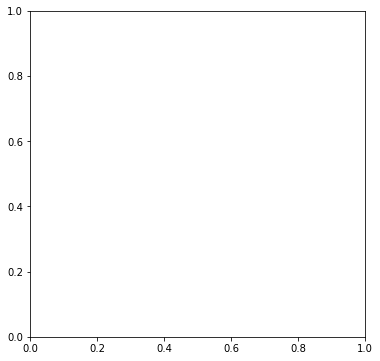

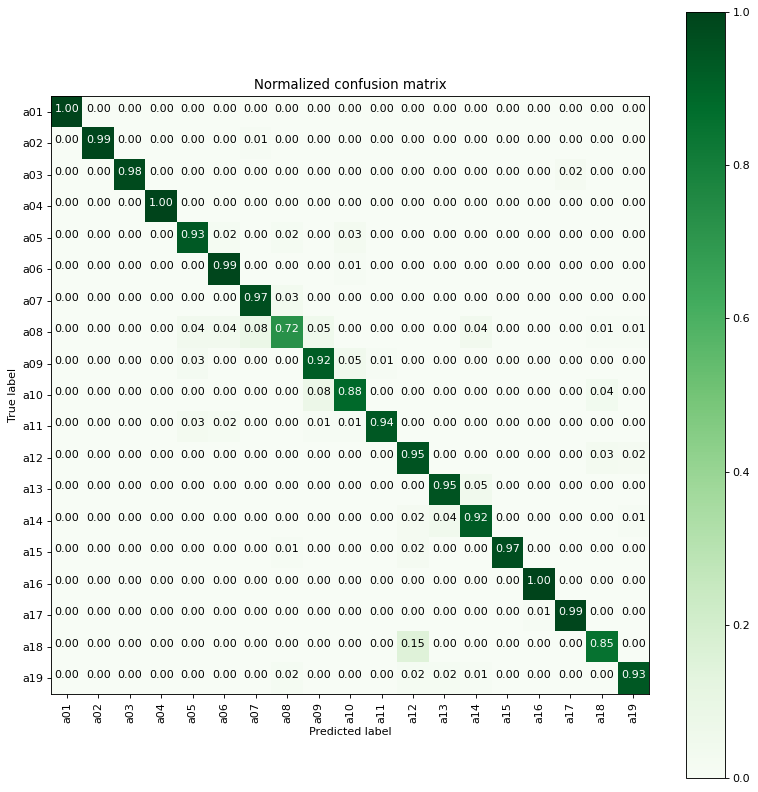

In [105]:
rfc = RandomForestClassifier()
rf_model=perform_model(rfc, X_train, y_train, X_test, y_test,class_labels=labels)
rf_model

### gradient boosting classifier

training the model..
Done....!

==> training time:- 0:00:16.481000

Predicting test data
Done....!

==> testing time:- 0:00:00.052000

==> Accuracy:- 0.9402412280701754


 ********Confusion Matrix********

 [[ 91   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0  87   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0
    0]
 [  0   0   0  88   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0  96   3   0   2   1   2   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0 103   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0  89   3   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   1   4  10  66   3   4   0   0   1   5   0   0   0   1
    3]
 [  0   0   0   0   3   1   0   0 100   5   1   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   7  68   0   0   0   0   0   

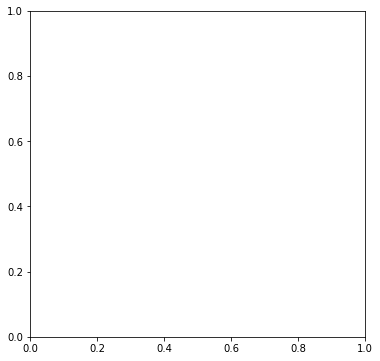

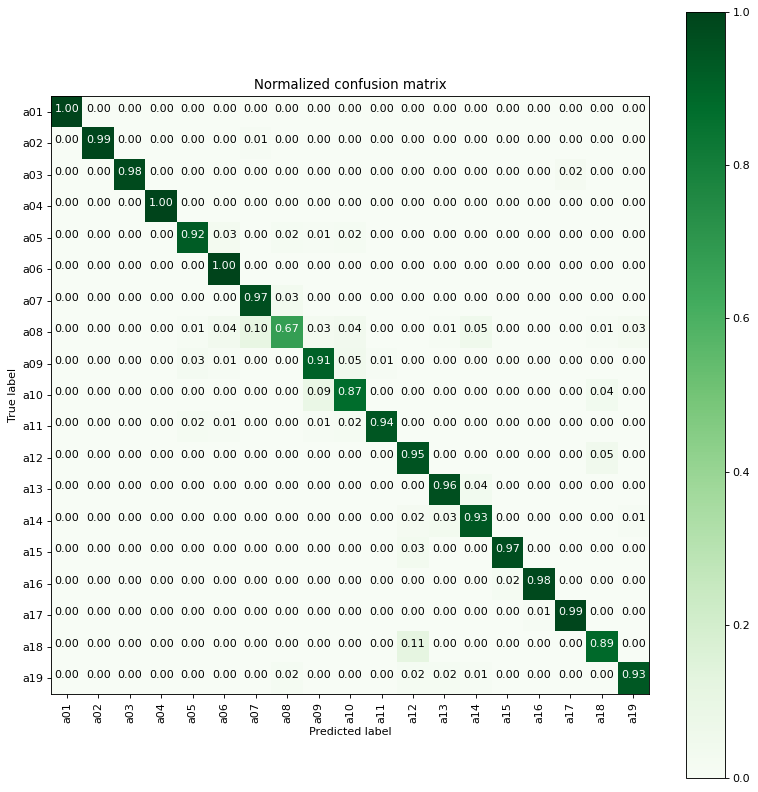

In [95]:
gb = GradientBoostingClassifier()
gb_model=perform_model(rfc, X_train, y_train, X_test, y_test,class_labels=labels)
gb_model

In [97]:
gb.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
disp=plot_roc_curve(gb, X_test, Y_test)
disp

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [162]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [163]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [164]:
y_train = y_train.long()
y_test = y_test.long()

In [165]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 


(torch.Size([7296, 1170]),
 torch.Size([1824, 1170]),
 torch.Size([7296]),
 torch.Size([1824]))

In [166]:
training_samples = TensorDataset(X_train, y_train)
test_samples = TensorDataset(X_test, y_test)

train_loader = DataLoader(training_samples, batch_size=64, shuffle=True)
valid_loader = DataLoader(test_samples, batch_size=64, shuffle=True)

In [167]:
class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
       .
        """

        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)


    def forward(self, x):
        """
       
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(np.random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred
      
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1170, 100, 19

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)
# making our model operate at double precision.
model = model.double()

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
# since it is multiclass classification problem, we are using CrossEntropyLoss, instead of MSEloss
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 1e-2 # alpha
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizers

for epoch in range(500):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data

    if (epoch + 1) % 100 == 0:
        print('Epoch : %d,  loss: %.3f' %
              (epoch + 1, running_loss / 64))
    running_loss = 0.0

print('Finished Training')

Epoch : 100,  loss: 1.173
Epoch : 200,  loss: 0.830
Epoch : 300,  loss: 0.680
Epoch : 400,  loss: 0.650
Epoch : 500,  loss: 0.664
Finished Training


In [ ]:
 For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.

In [168]:
# pass it through the model
X_test_var = Variable(X_test, volatile=True)
scores = model(X_test_var)
_, preds = torch.max(scores, dim=1)

accuracy_score(preds.data.numpy(), y_test.numpy())

<ipython-input-168-de52482e4f77>:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  X_test_var = Variable(X_test, volatile=True)


0.8596491228070176

### PCA

try with PCA to see whether 9120x1170 fairs better or 9120x40

In [111]:
from sklearn.decomposition import PCA
X = actual
pca = PCA(n_components=40)
pca.fit(X)
X_dash = pca.transform(X)

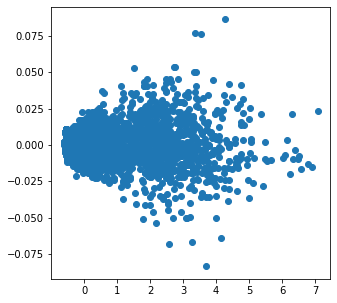

In [118]:
plt.figure(figsize = (5,5))
plt.scatter(X_dash[:,0],X_dash[:,39])
plt.show()

In [136]:
X_dash # the reduced matrix.


array([[-5.56408088e-01,  2.82491226e-05,  4.18084225e-04, ...,
         2.79633577e-03,  4.96661456e-04, -1.57624137e-03],
       [-5.55707576e-01,  1.79318883e-05,  4.19020170e-04, ...,
         3.58153377e-03,  8.50752823e-04, -2.05115087e-03],
       [-5.56088048e-01,  2.84927560e-05,  4.17309669e-04, ...,
         2.88050192e-03,  5.59577374e-04, -1.54900339e-03],
       ...,
       [ 5.44728749e-01, -8.36528255e-02, -7.06172376e-02, ...,
        -2.73027039e-03, -2.90169891e-03,  3.68517592e-02],
       [ 9.44722781e-01,  4.37066939e-04, -1.28225518e-02, ...,
        -1.00761373e-02, -1.54419632e-02, -4.93149280e-03],
       [ 1.98182134e+00,  3.82713822e-03,  3.52894440e-02, ...,
        -2.83749418e-02, -1.54279305e-02, -1.62476592e-02]])

In [137]:
new_df = pd.DataFrame(X_dash) # passing the array into a dataframe.


In [138]:
new_df.head()


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.556408,0.000028,0.000418,0.000036,-0.000713,-0.000724,0.001234,-0.000199,0.002731,0.012509,...,-0.000256,-0.000064,0.000281,0.000153,-0.000026,-0.000836,0.003419,0.002796,0.000497,-0.001576
1,-0.555708,0.000018,0.000419,0.000021,-0.000703,-0.000718,0.001231,-0.000156,0.002711,0.012504,...,-0.000385,0.000170,0.000117,0.000206,0.000019,-0.001139,0.003907,0.003582,0.000851,-0.002051
2,-0.556088,0.000028,0.000417,0.000039,-0.000715,-0.000728,0.001247,-0.000215,0.002794,0.012733,...,-0.000289,-0.000041,0.000329,0.000222,0.000167,-0.000898,0.003403,0.002881,0.000560,-0.001549
3,-0.555757,0.000019,0.000425,0.000024,-0.000701,-0.000714,0.001223,-0.000171,0.002714,0.012477,...,-0.000219,-0.000108,0.000212,0.000121,-0.000067,-0.000782,0.003404,0.002836,0.000426,-0.001647
4,-0.555139,0.000005,0.000428,0.000008,-0.000681,-0.000712,0.001199,-0.000148,0.002652,0.012260,...,-0.000183,0.000294,-0.000058,0.000433,0.000297,-0.001159,0.003651,0.003394,0.000734,-0.001825


In [139]:
new_df.shape


(9120, 40)

In [140]:
new_df['patient'] = patient_label_list  # setting the labels along with the reduced df
new_df['activity'] = activity_label_list

In [141]:
new_df.head()


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,patient,activity
0,-0.556408,0.000028,0.000418,0.000036,-0.000713,-0.000724,0.001234,-0.000199,0.002731,0.012509,...,0.000281,0.000153,-0.000026,-0.000836,0.003419,0.002796,0.000497,-0.001576,p1,a01
1,-0.555708,0.000018,0.000419,0.000021,-0.000703,-0.000718,0.001231,-0.000156,0.002711,0.012504,...,0.000117,0.000206,0.000019,-0.001139,0.003907,0.003582,0.000851,-0.002051,p1,a01
2,-0.556088,0.000028,0.000417,0.000039,-0.000715,-0.000728,0.001247,-0.000215,0.002794,0.012733,...,0.000329,0.000222,0.000167,-0.000898,0.003403,0.002881,0.000560,-0.001549,p1,a01
3,-0.555757,0.000019,0.000425,0.000024,-0.000701,-0.000714,0.001223,-0.000171,0.002714,0.012477,...,0.000212,0.000121,-0.000067,-0.000782,0.003404,0.002836,0.000426,-0.001647,p1,a01
4,-0.555139,0.000005,0.000428,0.000008,-0.000681,-0.000712,0.001199,-0.000148,0.002652,0.012260,...,-0.000058,0.000433,0.000297,-0.001159,0.003651,0.003394,0.000734,-0.001825,p1,a01


In [143]:
new_df.to_csv('pcafilewlabels.csv', header = False, index= False )
